In [1]:
import pandas as pd
import numpy as np
from symbol import Symbol
from index import Index
from portifolio import Portifolio
from datetime import datetime
import os
import matplotlib.pyplot as plt
from bqplot import pyplot as bplt
import seaborn as sns
from dateutil.relativedelta import relativedelta

sns.set(context='notebook', style="dark", palette="muted", color_codes=True)

%matplotlib inline

In [2]:
def plot_close(hist_data, symbol_list):
    grouped_data = hist_data.groupby('symbol')
    try:
        bplt.close(1)
    except:
        pass
    bplt.figure(1, title='Line Chart')
    bplt.clear()
    for symbol in symbol_list:
        adjclose = grouped_data.get_group(symbol).set_index('date').adj_close
        bplt.plot(x=adjclose.index, y=adjclose, marker_str=symbol)
        bplt.legend()
    
    bplt.show()

def plot_returns(returns_data, symbol_list):
    try:
        bplt.close(1)
    except:
        pass
    bplt.figure(1, title='Line Chart')
    bplt.clear()
    for symbol in symbol_list:
        bplt.plot(x=returns_data.index, y=returns_data[[symbol]])
        bplt.legend()
    
    bplt.show()

In [75]:
s= Symbol()
i = Index()
p = Portifolio()

In [77]:
ret = s.get_symbol_data(null_count=5)
ret = ret.fillna(0, limit=5)
iret = i.get_index_returns('nifty_50')
iret = iret.fillna(0, limit=5)
close = s.get_symbol_data('close', null_count=5)
common_index = np.intersect1d(ret.index, iret.index)
ret = ret.loc[common_index]
iret = iret.loc[common_index]
infy_ret = ret.infy
indret = iret.nifty_50
len(ret), len(ret.columns), len(iret)

(5240, 40, 5240)

In [62]:
def holding_period_returns(returns=None, price=None):
    if price is None:
        price = p.prices(returns).bfill()
    price = (price.ix[-1, :] - price.ix[0, :])/price.ix[0, :]
    return price

def describe_returns(returns, benchmark_returns):
    returns = pd.DataFrame(returns)
    common_columns = np.intersect1d(returns.index, benchmark_returns.index)
    returns = returns.loc[common_columns]
    benchmark_returns = benchmark_returns.loc[common_columns]
    price = returns.apply(holding_period_returns)
    returns_describe = pd.DataFrame(price*100, columns=['holding_period_return'])
    risk_frr, _ = p.set_risk_free_rate(returns)
    excess_returns = returns - risk_frr 
    price = excess_returns.apply(holding_period_returns)
    returns_describe = returns_describe.join(100*price.rename('excess_returns_rf'))
    for symbol in returns.columns:
        excess_returns[symbol] = returns[symbol] - benchmark_returns.ix[:, 0]
    price = excess_returns.apply(holding_period_returns)
    returns_describe = returns_describe.join(100*price.rename('excess_returns_bench'))
    returns_describe = returns_describe.join(returns.describe().T.drop('std', axis=1))
    returns_describe['count'] = returns_describe['count'].astype(int)
    returns_describe = returns_describe.rename(
        columns={
            'count': 'num_returns',
            'mean': 'mean_returns',
            'min': 'min_returns',
            'max': 'max_returns',
            '25%': '25_pctile',
            '50%': '50_pctile',
            '75%': '75_pctile'
        })
    percentiles = returns_describe.ix[:, ['25_pctile', '50_pctile', '75_pctile']].copy()
    returns_describe = returns_describe.drop(percentiles.columns, axis=1)
    returns_describe = returns_describe.join(returns.median().rename('median_returns'))

    pos_pctile = returns[returns>0].count() / returns.count()
    returns_describe = returns_describe.join(pos_pctile.rename('pos_pctile'))
    capm = p.calculate_capm(returns, benchmark_returns).set_index('symbol').drop('benchmark', axis=1)
    returns_describe = returns_describe.join(capm)
    sharpe_ratio = p.sharpe_ratio(returns)
    returns_describe = returns_describe.join(sharpe_ratio)
    sortino_ratio = p.sortino_ratio(returns, 0)
    returns_describe = returns_describe.join(sortino_ratio)
    upside_potential_ratio = p.upside_potential_ratio(returns, 0)
    returns_describe = returns_describe.join(upside_potential_ratio)
        
#     returns_describe = returns_describe.join(percentiles)
    return returns_describe.round(4)
desc_ret = describe_returns(ret, iret)
# desc_ret15 = describe_returns(ret['2010':'2015'], iret['2010':'2015'])
# desc_ret16 = describe_returns(ret['2016'], iret['2016'])
# describe_returns(ret.ix[:, 0:4], iret)


In [63]:
desc_ret

,holding_period_return,excess_returns_rf,excess_returns_bench,num_returns,mean_returns,min_returns,max_returns,median_returns,pos_pctile,alpha,beta,std_dev,r_square,sharpe_ratio,sortino_ratio,upside_potential_ratio
infy,76759.902,20303.7492,8934.499,5236,0.0013,-0.239,0.1552,0.0004,0.5117,0.0009,0.937,0.0256,0.3221,2.9154,4.2848,1.1646


In [67]:
idat = s.get_symbol_hist('infy').set_index('date')

In [78]:
idat[abs(np.log(idat.close/idat.prev_close)*100) > 30]

,symbol,prev_close,open,high,low,last,close,vwap,volume,turnover,pct_deliverble,simple_returns,log_returns,daily_volatility
date,,,,,,,,,,,,,,
1996-07-08,infy,0.00,698.00,700.00,693.75,NaN,693.75,698.29,600.0,4.190000e+05,NaN,-0.006504,-0.006523,0.001598
1997-08-20,infy,2300.15,1081.00,1224.00,1081.00,NaN,1207.15,1194.01,37400.0,4.465600e+07,NaN,0.012155,0.010945,0.002681
1999-02-10,infy,5001.00,2525.00,2542.50,2430.00,2452.00,2452.00,2481.14,75836.0,1.881600e+08,NaN,-0.011541,-0.011814,0.002894
2000-01-27,infy,14109.40,7570.00,7600.00,7293.00,7405.00,7390.75,7464.80,202403.0,1.510899e+09,NaN,-0.009782,-0.009969,0.002442
2003-04-10,infy,4151.95,4100.00,4100.00,3019.00,3050.00,3049.75,3414.63,3297209.0,1.125875e+10,32.03,-0.088995,-0.113010,0.027682
2004-07-01,infy,5524.10,1395.00,1415.70,1359.20,1409.95,1408.80,1387.46,1767215.0,2.451940e+09,15.93,0.015297,0.015264,0.003739
2006-07-13,infy,3385.65,1748.00,1799.00,1666.00,1679.00,1681.95,1680.32,1423289.0,2.391584e+09,47.76,0.000932,0.000970,0.000237
2014-12-02,infy,4349.85,2164.95,2164.95,2115.00,2127.10,2126.60,2135.45,2663748.0,5.688310e+09,71.38,-0.004088,-0.004153,0.001017
2015-06-15,infy,1975.05,976.95,998.80,968.00,994.00,990.45,990.17,2618213.0,2.592487e+09,55.18,0.000287,0.000283,0.000069


In [72]:
idat['1999-02']

,symbol,prev_close,open,high,low,last,close,vwap,volume,turnover,pct_deliverble,simple_returns,log_returns,daily_volatility
date,,,,,,,,,,,,,,
1999-02-01,infy,4715.00,4700.00,4714.0,4500.0,4535.00,4535.00,4582.50,38630.0,177022000.0,NaN,-0.038176,-0.038924,0.009534
1999-02-02,infy,4535.00,4506.00,4620.0,4420.0,4420.05,4420.05,4518.03,60129.0,271664000.0,NaN,-0.025347,-0.025674,0.006289
1999-02-03,infy,4420.05,4505.00,4649.0,4501.0,4649.00,4649.00,4575.13,38584.0,176527000.0,NaN,0.051798,0.050501,0.012370
1999-02-04,infy,4649.00,4650.00,4730.0,4570.0,4585.00,4585.00,4656.64,28670.0,133506000.0,NaN,-0.013766,-0.013862,0.003395
1999-02-05,infy,4585.00,4592.00,4951.8,4570.0,4951.80,4951.80,4820.97,109393.0,527381000.0,NaN,0.080000,0.076961,0.018852
1999-02-08,infy,4951.80,5100.00,5150.0,4555.7,4670.00,4670.00,4856.35,81904.0,397755000.0,NaN,-0.056909,-0.058592,0.014352
1999-02-09,infy,4670.00,4650.00,5025.0,4650.0,5001.00,5001.00,4908.34,71561.0,351246000.0,NaN,0.070878,0.068479,0.016774
1999-02-10,infy,5001.00,2525.00,2542.5,2430.0,2452.00,2452.00,2481.14,75836.0,188160000.0,NaN,-0.011541,-0.011814,0.002894
1999-02-11,infy,2452.00,2473.00,2480.0,2431.5,2464.00,2464.00,2454.85,25209.0,61884000.0,NaN,0.004894,0.004882,0.001196


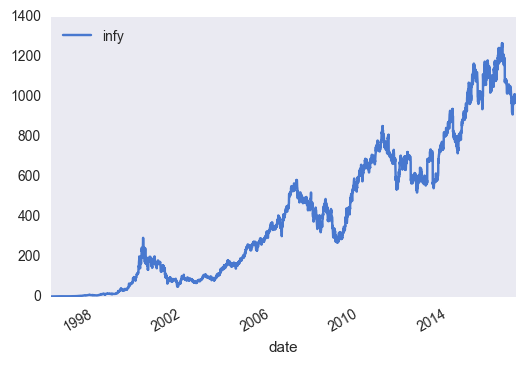

In [60]:
ret = s.get_symbol_data(null_count=5)
ret = np.log(close.infy/close.infy.shift(1))
ret[abs(ret) > 30/100] = 0
iclos = pd.DataFrame(p.prices(ret))
iclos = (iclos/iclos.ix[-1, :])*close.infy.ix[-1]
iclos.plot()

In [ ]:
conditions = [
    'holding_period_return > 0',
    'excess_returns_rf > 0',
    'excess_returns_bench > 0',
    'num_returns > 500',
    'upside_potential_ratio > 1',
    'pos_pctile > 0.50',
# #     'min_returns > -0.15',
#     'std_dev < 0.03',
#     'sortino_ratio > 1'
]
str_cond = ' & '.join(conditions)
if str_cond == '':
    ind = desc_ret.index
else:
    ind = desc_ret.query(str_cond).index
desc_ret.loc[ind].sort_values('excess_returns_bench', ascending=False)
# desc_ret.loc['infy']
(desc_ret.excess_returns_bench/desc_ret.num_returns).sort_values(ascending=False)
pq = desc_ret.query('num_returns > 1000 & excess_returns_bench > 0').eval('excess_returns_bench/num_returns').sort_values(ascending=False)
(pq/desc_ret.std_dev).dropna().sort_values(ascending=False)

In [ ]:
conditions = [
    'holding_period_return > 0.1',
    'upside_potential_ratio > 1',
    'pos_pctile > 0.5',
    'min_returns > -0.15',
    'std_dev < 0.03',
    'sortino_ratio > 1'
]
str_cond = ' & '.join(conditions)
ind = desc_ret16.query(str_cond).index
desc_ret16.loc[ind]

In [ ]:
desc_ret16.loc[ind]

In [ ]:
conditions = [
    'holding_period_return > 5 * 0.1',
    'upside_potential_ratio > 1',
    'pos_pctile > 0.5',
    'min_returns > -0.15',
    'std_dev < 0.03',
    'sortino_ratio > 1',
    'beta > 0.8'
]
str_cond = ' & '.join(conditions)
ind = desc_ret15.query(str_cond).index
desc_ret15.loc[ind]

In [ ]:
desc_ret16[desc_ret16.index.isin(ind)]

In [ ]:
vol = s.get_symbol_data(data='volatility', start='2015',null_count=5, volume=1000)
vol.mean().sort_values().head()

In [ ]:
np.sqrt(np.floor_divide(len(returns), interval)+1)

In [ ]:
iport = s.returns[['INFY', 'BPCL']]['2000':].fillna(0)/100
start_value = 10000
weights = np.ones(len(iport.columns))/len(iport.columns)
myport = pd.DataFrame(0, index=iport.index.copy(), columns = iport.columns.copy())
myport.ix[0, :] = start_value/(len(iport.columns))
myport = myport.ix[0] * np.exp(iport.cumsum())
myport['value'] = myport.sum(axis=1)
myport.tail()
# # myport = myport/myport.ix[0]

In [ ]:
def calc_portfolio_var(returns, weights=None):
    if weights is None: 
        weights = np.ones(returns.columns.size) / \
        returns.columns.size
    sigma = np.cov(returns.T,ddof=0)
    var = (weights * sigma * weights.T).sum()
    return var

In [ ]:
def sharpe_ratio(returns, weights = None, risk_free_rate = 0.045):
    n = returns.columns.size
    if weights is None: weights = np.ones(n)/n
    # get the portfolio variance
    var = calc_portfolio_var(returns, weights)
    # and the means of the stocks in the portfolio
    means = returns.mean()
    # and return the sharpe ratio
    risk_free_rate = np.log(1+risk_free_rate)/365
    return (means.dot(weights) - risk_free_rate)/np.sqrt(var)
sharpe_ratio(iport)
# iport.mean()

In [ ]:
def y_f(x): return 2+x**2

import scipy as sp
import scipy.optimize as scopt
import scipy.stats as spstats
scopt.fmin(y_f, 1000)

In [ ]:
def negative_sharpe_ratio_n_minus_1_stock(weights, 
                                          returns, 
                                          risk_free_rate):
    """
    Given n-1 weights, return a negative sharpe ratio
    """
    weights2 = sp.append(weights, 1-np.sum(weights))
    return -sharpe_ratio(returns, weights2, risk_free_rate)
def optimize_portfolio(returns, risk_free_rate):
    """ 
    Performs the optimization
    """
    # start with equal weights
    w0 = np.ones(returns.columns.size-1, 
                 dtype=float) * 1.0 / returns.columns.size
    # minimize the negative sharpe value
    w1 = scopt.fmin(negative_sharpe_ratio_n_minus_1_stock, 
                    w0, args=(returns, risk_free_rate))
    # build final set of weights
    final_w = sp.append(w1, 1 - np.sum(w1))
    # and calculate the final, optimized, sharpe ratio
    final_sharpe = sharpe_ratio(returns, final_w, risk_free_rate)
    return (final_w, final_sharpe)
optimize_portfolio(iport, 0.045)

In [ ]:
def objfun(W, R, target_ret):
    stock_mean = np.mean(R,axis=0)
    port_mean = np.dot(W,stock_mean) # portfolio mean
    cov=np.cov(R.T) # var-cov matrix
    port_var = np.dot(np.dot(W,cov),W.T) # portfolio variance
    penalty = 2000*abs(port_mean-target_ret)# penalty 4 deviation
    return np.sqrt(port_var) + penalty # objective function
def calc_efficient_frontier(returns):
    result_means = []
    result_stds = []
    result_weights = []
    
    means = returns.mean()
    min_mean, max_mean = means.min(), means.max()
    
    nstocks = returns.columns.size
    
    for r in np.linspace(min_mean, max_mean, 100):
        weights = np.ones(nstocks)/nstocks
        bounds = [(0,1) for i in np.arange(nstocks)]
        constraints = ({'type': 'eq', 
                        'fun': lambda W: np.sum(W) - 1})
        results = scopt.minimize(objfun, weights, (returns, r), 
                                 method='SLSQP', 
                                 constraints = constraints,
                                 bounds = bounds)
        if not results.success: # handle error
            raise Exception(result.message)
        result_means.append(np.round(r,4)) # 4 decimal places
        std_=np.round(np.std(np.sum(returns*results.x,axis=1)),6)
        result_stds.append(std_)
        
        result_weights.append(np.round(results.x, 5))
    return {'Means': result_means, 
            'Stds': result_stds, 
            'Weights': result_weights}
frontier_data = calc_efficient_frontier(iport)
# first five risk levels
frontier_data['Stds'][:5]
# first five mean returns
frontier_data['Means'][:5]
# first five sets of optimal weights
frontier_data['Weights'][:5]

In [ ]:
def plot_efficient_frontier(frontier_data):
    plt.figure(figsize=(12,8))
    plt.title('Efficient Frontier')
    plt.xlabel('Standard Deviation of the porfolio (Risk))')
    plt.ylabel('Return of the portfolio')
    plt.plot(frontier_data['Stds'], frontier_data['Means'], '--'); 
    
plot_efficient_frontier(frontier_data)

In [ ]:
z = spstats.norm.ppf(0.95)
VaR = 10000 * (z * iport.INFY.std())
VaR

In [ ]:
import matplotlib.mlab as mlab
# draw a 99% one-tail confidence interval
x = np.linspace(-4,4,101)
y = np.exp(-x**2/2) / np.sqrt(2*np.pi)
x2 = np.linspace(-4,-2.33,101)
y2 = np.exp(-x2**2/2) / np.sqrt(2*np.pi)
f = plt.figure(figsize=(12,8))
plt.plot(x,y*100, linewidth=2)
xf, yf = mlab.poly_between(x2, 0*x2, y2*100)
plt.fill(xf, yf, facecolor='g', alpha=0.5)
plt.gca().set_xlabel('z-score')
plt.gca().set_ylabel('Frequency %')
plt.title("VaR based on the standard normal distribution")
bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="w", ec="b", lw=2)
t = f.text(0.25, 0.35, "99% VaR confidence level", ha="center", va="center", 
           rotation=270,
            size=15,
            bbox=bbox_props)
plt.savefig('5104OS_09_21.png', bbox_inches='tight', dpi=300)

In [ ]:
ret[['GALLISPAT', 'INFY']].plot()

In [ ]:
get_hist_data(hist_data, 'INFY')['2001-04']

In [ ]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [ ]:
ret.dropna(axis=1)

In [ ]:
symbol_list['INFY']